# Desafío - Máquinas de Soporte Vectorial
## Daniela Hurtado

# Ejercicio 1: Preparar el ambiente de trabajo

* Importe todas las librerías a utilizar.
* Fije los parámetros de los gráficos con plt.Rcparams .
* Excluya las columnas id y Unnamed: 32 de la base de datos.
* Recodifique el vector objetivo diagnosis a numérico para poder procesarlo posteriormente.

In [1]:
# Librerías clásicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#formato de graficos
plt.style.use('seaborn')

#parámetro de los gráficos
plt.rcParams['figure.figsize']=(10, 6)

# librerías enfocadas en Machine-Learning
from sklearn.svm import SVC# importamos maquinas de clasificacion vectorial
from sklearn.model_selection import train_test_split # Matrices de entrenamiento y validación
from sklearn.preprocessing import StandardScaler # estandarización de atributos
from sklearn.pipeline import Pipeline #permite concatenar múltiples pasos de procesamiento y preprocesamiento en un estimador generado por algún método de scikit-learn .
from sklearn.metrics import classification_report # reporte de metricas
from sklearn.preprocessing import LabelEncoder #transforma etiquetas a numericas
from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import GridSearchCV
#from matplotlib.gridspec import GridSpec

In [2]:
# importamos la data y consultamos con un sample
df = pd.read_csv('breast_cancer.csv')
df.sample()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
66,859464,B,9.465,21.01,60.11,269.4,0.1044,0.07773,0.02172,0.01504,...,31.56,67.03,330.7,0.1548,0.1664,0.09412,0.06517,0.2878,0.09211,NaN


In [3]:
#borramos las q nos indica el ejercicio
df = df.drop(['id', 'Unnamed: 32'], axis=1)

In [4]:
# comprobamos q se borraron
df.sample()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
405,B,10.94,18.59,70.39,370.0,0.1004,0.0746,0.04944,0.02932,0.1486,...,12.4,25.58,82.76,472.4,0.1363,0.1644,0.1412,0.07887,0.2251,0.07732


In [5]:
# Hacemos un value_counts para ver la cantidada de datos
# Diagnosis (M = malignant, B = benign)
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [6]:
# reemplazamos a numericos
#df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis'])

# -1 minoritaria, 1 mayoritaria
df = df.replace('B', 1 )
df = df.replace('M', -1)

In [7]:
# hacemos otros value_counts para serciorarnos que variable quedo como 1 y -1
df['diagnosis'].value_counts()

 1    357
-1    212
Name: diagnosis, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null int64
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave points_se          569 no

# Ejercicio 2: Visualizando la distribución de los atributos

* Para cada uno de los atributos, grafique los histogramas condicional a cada clase del vector objetivo.
* Agregue las medias correspondientes y reporte a grandes rasgos cuáles son los atributos con una mayor similitud en la distribución.

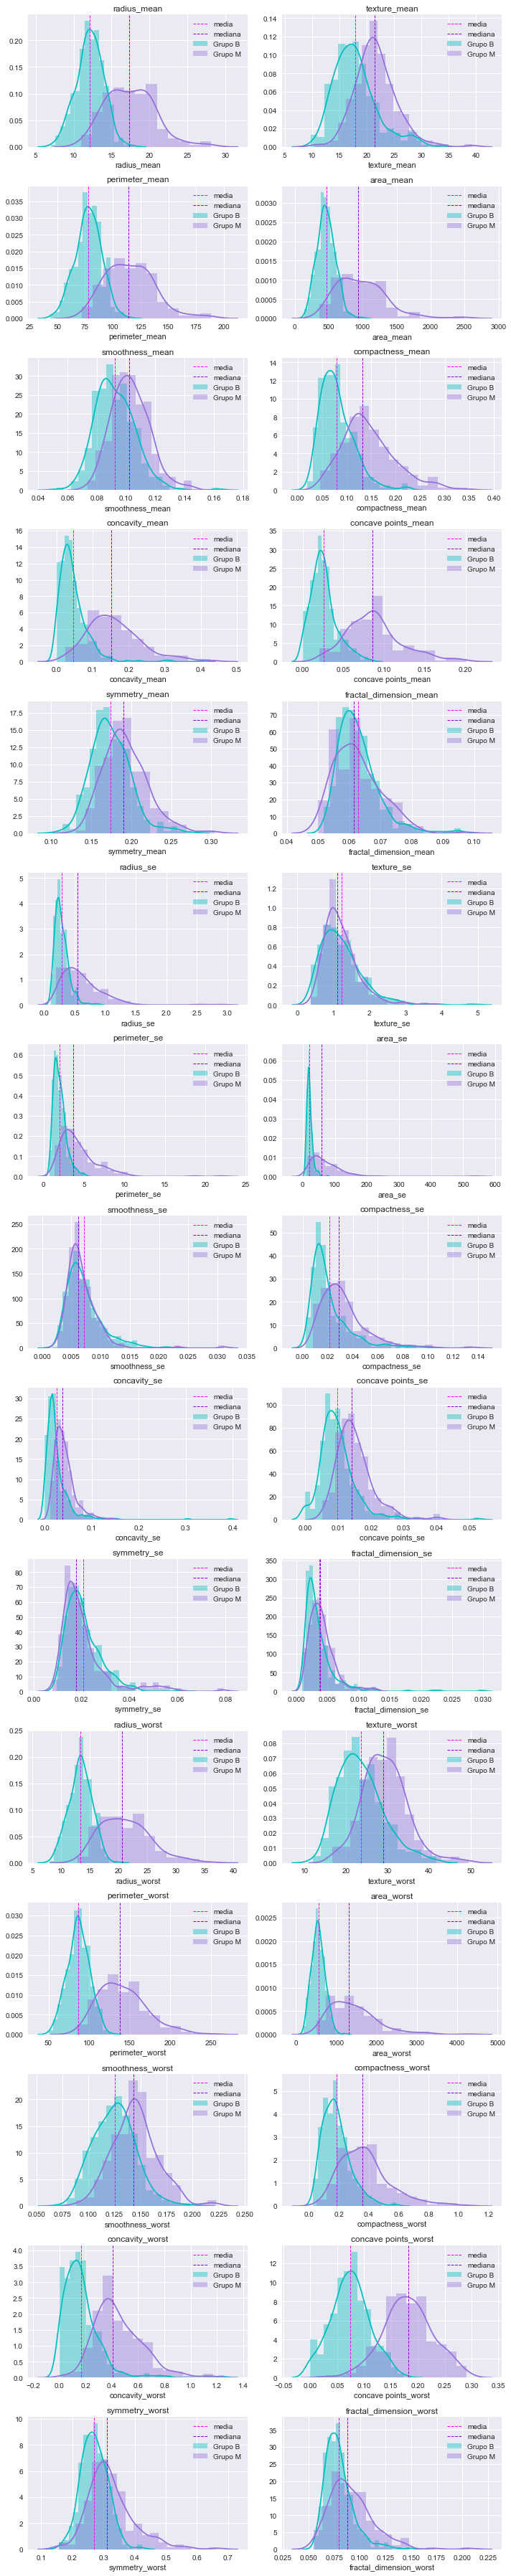

In [9]:
plt.figure(figsize=(10,50))
for n,i in enumerate (df.drop(columns =['diagnosis']).columns):
    plt.subplot(15,2, n+1)
    grupo_B = df[df['diagnosis']==1][i]
    grupo_M = df[df['diagnosis']==-1][i]
    
    sns.distplot(grupo_B, color='c', label= 'Grupo B')
    sns.distplot(grupo_M, color='mediumpurple', label= 'Grupo M')
    
    plt.axvline(np.mean(grupo_B), color='magenta',linestyle='--', label = "media", lw=1)
    plt.axvline(np.median(grupo_M), color='darkviolet', linestyle='--', label='mediana', lw=1)
   
    plt.legend()
    plt.title(i)
    plt.tight_layout()

* Los atributos con mayor similitud de distribución son: __smoothness_mean, symmetry_mean, fractal_dimension_mean, smoothness_se, concave points_se, symmetry_se, fractal_dimension_se, smoothness_worst y symmetry_worst__

# Ejercicio 3: Estimando el porcentaje de overlap en los atributos

* Parte de las virtudes de las Máquinas de Soporte Vectorial es la capacidad de lidiar con clases no separables mediante el proceso de kernelización. Resulta que un aspecto importante que muchas veces se obvía es medir la noseparabilidad de los atributos, condicional a cada clase del vector objetivo.

* El procedimiento para estimar el rango de noseparabilidad entre clases se implementa en Python de la siguiente manera:

In [10]:
def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
            # for a specific attribute
            df[df[target] == unique_value][attribute],
            # define percentage
            bins=perc,
            # limit empirical range for comparison
            range=[empirical_lower_bound, empirical_upper_bound]
        )
        # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp

    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_-1"])
    intersection = np.true_divide(np.sum(get_minima), 
                                  np.sum(tmp_hist_holder["h_-1"]))
    
    return intersection

* La intersección devolverá el porcentaje de comunalidad entre ambas clases, donde mayores niveles indican una mayor comunalidad.

* Utilizando la función, genere un dataframe donde almacenará el nombre del atributo y su porcentaje. Ordene este dataframe de forma descendente y preserve.

In [11]:
histogram_overlap(df,'radius_mean', 'diagnosis', perc=100)

0.3113207547169811

In [12]:
variables = df.drop(columns = 'diagnosis').columns
overlap = [histogram_overlap(df, i,'diagnosis', perc=100) for i in variables]

diccionario = {'Variable': variables, 'Overlap_value': overlap}

new_data = pd.DataFrame.from_dict(diccionario).sort_values(by= ['Overlap_value'], ascending=False)
new_data

,Variable,Overlap_value
19,fractal_dimension_se,1.000000
14,smoothness_se,0.995283
9,fractal_dimension_mean,0.990566
18,symmetry_se,0.957547
11,texture_se,0.924528
15,compactness_se,0.882075
4,smoothness_mean,0.877358
8,symmetry_mean,0.858491
17,concave points_se,0.853774
29,fractal_dimension_worst,0.830189


# Ejercicio 4: Selección del modelo por GridSearchCV

* Entrene una serie de modelos SVC con los siguientes hiperparámetros:
    * C: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] .
    * gamma: [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10] .
    * Validaciones cruzadas: 10.
* Genere un heatmap en base a los puntajes estimados con GridSearchCV .

tip: Vea cómo acceder a la llave mean_test_score en el diccionario cv_results_ .

In [13]:
# Estandarizamos la matriz de atributos
X_scaled = StandardScaler().fit_transform(df.loc[:,'radius_mean':'fractal_dimension_worst'])
# Generamos conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_scaled,df['diagnosis'], random_state=23748, test_size=.33)


In [14]:
# rango de C
c_param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# rango de Gamma
gamma_param_range = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

In [39]:
#Instancimos el modelo
from sklearn.model_selection import GridSearchCV

params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}

estimate_gs_svc = GridSearchCV(SVC(kernel='rbf'), param_grid= params, cv=10, n_jobs=-1).fit(X_train, y_train)

In [52]:
# el mejor puntaje de la combinación de hiperparámetros
estimate_gs_svc.best_score_

0.989501312335958

In [51]:
# a que combinacion de hiperparámetors estaba asciado best_score
estimate_gs_svc.best_params_

{'C': 100, 'gamma': 0.001}

In [47]:
result_param = estimate_gs_svc.cv_results_['mean_test_score']

In [48]:
result_param

array([0.62992126, 0.62992126, 0.62992126, 0.62992126, 0.62992126,
       0.62992126, 0.62992126, 0.62992126, 0.62992126, 0.62992126,
       0.62992126, 0.62992126, 0.62992126, 0.62992126, 0.62992126,
       0.62992126, 0.62992126, 0.62992126, 0.62992126, 0.62992126,
       0.62992126, 0.62992126, 0.62992126, 0.70603675, 0.95275591,
       0.94750656, 0.62992126, 0.62992126, 0.62992126, 0.73490814,
       0.95275591, 0.97112861, 0.96062992, 0.62992126, 0.62992126,
       0.62992126, 0.95275591, 0.97900262, 0.98687664, 0.96062992,
       0.62992126, 0.62992126, 0.62992126, 0.9816273 , 0.98950131,
       0.9816273 , 0.96062992, 0.62992126, 0.62992126, 0.73490814,
       0.98687664, 0.9816273 , 0.97637795, 0.96062992, 0.62992126,
       0.62992126])

In [55]:
cv_params = np.array(result_param).reshape(8,7)

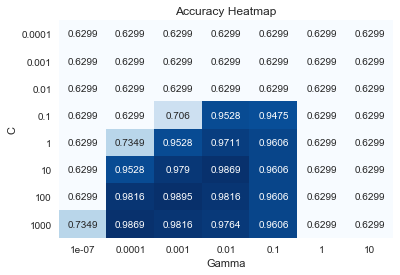

In [57]:
# Visualizamos heatmap
sns.heatmap(cv_params, annot=True, cmap='Blues',
            cbar=False, xticklabels=gamma_param_range,
            yticklabels=c_param_range, fmt=".4")

plt.xlabel('Gamma');
plt.ylabel('C');
plt.title('Accuracy Heatmap');

# Ejercicio 5: Validación del modelo en el hold-out sample

* Genere las predicciones del hold-out sample en base a la mejor combinación de hiperparámetros. Genere un reporte con las métricas de desempeño clásicas para los modelos de clasificación. Comente en qué casos el modelo presenta un desempeño deficiente.

In [59]:
refactor_svc_rbf = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel='rbf', C=100, gamma=0.001))
    ]
)

refactor_svc_rbf.fit(X_train, y_train)

yhat = refactor_svc_rbf.predict(X_test)

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

          -1       0.97      0.92      0.94        71
           1       0.95      0.98      0.97       117

   micro avg       0.96      0.96      0.96       188
   macro avg       0.96      0.95      0.95       188
weighted avg       0.96      0.96      0.96       188

